In [2]:
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

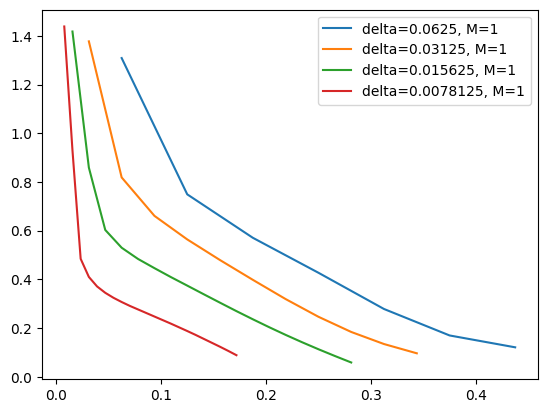

In [158]:
solver_name = "EKF1_2"
problem_name = "FHN"
prefix = f"{solver_name}_{problem_name}"
folder = "./EKF1_FHN"

deltas = 1/jnp.array([16,32,64,128])
Ns = 1/deltas
fineN = Ns**0
Mdeltas = jnp.ones((len(deltas),)) * (Ns)**0
T = 1.0
Ndeltas = T/deltas
for n in range(len(Ndeltas)):
    delta = deltas[n]
    N = int(Ndeltas[n])
    M = int(Mdeltas[n])
    fine = int(fineN[n])
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}_{M}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}_{fine}.npy')
    N = int(N)
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, T, N)
    ranged = range(N)
    plt.plot(ts, jnp.log(jnp.mean(jnp.linalg.norm(paths_1 - paths_2, axis=-1), axis=0)) / jnp.log(delta),
             label=f'delta={delta}, M={M}')
plt.legend()

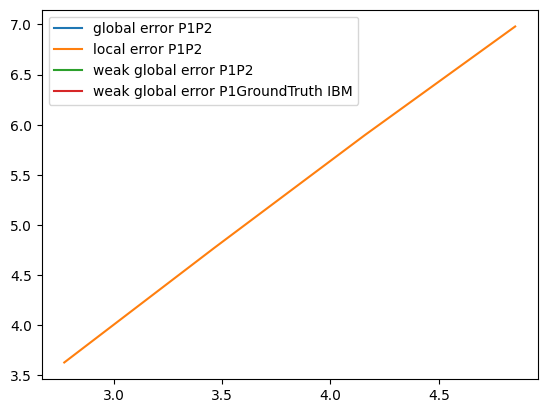

In [155]:
STRONG_GLOBAL_ERRORS_P1P2 = []
STRONG_LOCAL_ERRORS_P1P2 = []
WEAK_GLOBAL_ERRORS_P1P2 = []
WEAK_GLOBAL_ERRORS_P1GroundTruth = []
@partial(jnp.vectorize, signature="(d,x)->(d,d)")
def WEAK_POLYNOMIAL(x):
    return x @ x.T


COV_HYPOELLIPTIC_COMPONENT_ERRORS = []
for n in range(len(deltas)):
    N = int(Ndeltas[n])
    M = int(Mdeltas[n])
    fine = int(fineN[n])
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}_{M}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}_{fine}.npy')
    #paths = jnp.load(f'{folder}/{prefix}_paths_{N}_{fine}.npy')
    STRONG_GLOBAL_ERROR_P1P2 = jnp.mean(jnp.linalg.norm(paths_2 - paths_1, axis=-1), axis=0)[-1]
    STRONG_LOCAL_ERROR_P1P2 = jnp.mean(jnp.linalg.norm(paths_2[:, 1] - paths_1[:, 1], axis=-1), axis=0)
    
    MOMENT_P1 = WEAK_POLYNOMIAL(paths_1[...,jnp.newaxis])
    MOMENT_P2 = WEAK_POLYNOMIAL(paths_2[...,jnp.newaxis])
    
    WEAK_GLOBAL_ERROR_P1P2 = jnp.max(jnp.linalg.norm(jnp.linalg.norm(jnp.mean(MOMENT_P2, axis=0)-jnp.mean(MOMENT_P1, axis=0),axis=-1),axis=-1),axis=-1)
    STRONG_GLOBAL_ERRORS_P1P2.append(STRONG_GLOBAL_ERROR_P1P2)
    STRONG_LOCAL_ERRORS_P1P2.append(STRONG_LOCAL_ERROR_P1P2)
    WEAK_GLOBAL_ERRORS_P1P2.append(WEAK_GLOBAL_ERROR_P1P2)
    
    #ONLY FOR IBM
    WEAK_GLOBAL_ERROR_P1GroundTruth = jnp.linalg.norm(jnp.linalg.norm(jnp.mean(MOMENT_P1[:,-1,:], axis=0)-jnp.array([[4+1/3, 2+1/2],                                                            [2+1/2, 1+1]]),axis=-1),axis=-1)
    WEAK_GLOBAL_ERRORS_P1GroundTruth.append(WEAK_GLOBAL_ERROR_P1GroundTruth)
STRONG_GLOBAL_ERRORS_P1P2 = jnp.array(STRONG_GLOBAL_ERRORS_P1P2)
STRONG_LOCAL_ERRORS_P1P2 = jnp.array(STRONG_LOCAL_ERRORS_P1P2)
WEAK_GLOBAL_ERRORS_P1P2 = jnp.array(WEAK_GLOBAL_ERRORS_P1P2)
WEAK_GLOBAL_ERRORS_P1GroundTruth = jnp.array(WEAK_GLOBAL_ERRORS_P1GroundTruth)
plt.plot(-jnp.log(deltas), -jnp.log(STRONG_GLOBAL_ERRORS_P1P2), label='global error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(STRONG_LOCAL_ERRORS_P1P2), label='local error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(WEAK_GLOBAL_ERRORS_P1P2), label='weak global error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(WEAK_GLOBAL_ERRORS_P1GroundTruth), label='weak global error P1GroundTruth IBM')
plt.legend()

In [156]:
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_GLOBAL_ERRORS_P1P2))
print(linear_regressor.coef_)
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_LOCAL_ERRORS_P1P2))
print(linear_regressor.coef_)
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(WEAK_GLOBAL_ERRORS_P1P2))
print(linear_regressor.coef_)
linear_regressor = LinearRegression().fit(-jnp.log(deltas)[:-4].reshape(-1, 1), -jnp.log(WEAK_GLOBAL_ERRORS_P1GroundTruth[:-4]))
print(linear_regressor.coef_)


ValueError: Input y contains NaN.

In [120]:
jnp.save(f'{prefix}_STRONG_GLOBAL_ERRORS', jnp.array([deltas, STRONG_GLOBAL_ERRORS_P1P2]))
jnp.save(f'{prefix}_STRONG_LOCAL_ERRORS', jnp.array([deltas, STRONG_LOCAL_ERRORS_P1P2]))
jnp.save(f'{prefix}_WEAK_GLOBAL_ERRORS', jnp.array([deltas, WEAK_GLOBAL_ERRORS_P1P2]))
#jnp.save(f'{prefix}_WEAK_GLOBAL_ERRORS_P1GroundTruth', jnp.array([deltas, WEAK_GLOBAL_ERRORS_P1GroundTruth]))

In [121]:
STRONG_GLOBAL_ERRORS = jnp.load(f'{prefix}_STRONG_GLOBAL_ERRORS.npy')
STRONG_LOCAL_ERRORS = jnp.load(f'{prefix}_STRONG_LOCAL_ERRORS.npy')
WEAK_GLOBAL_ERRORS = jnp.load(f'{prefix}_WEAK_GLOBAL_ERRORS.npy')
#WEAK_GLOBAL_ERRORS_P1GroundTruth = jnp.load(f'{prefix}_WEAK_GLOBAL_ERRORS_P1GroundTruth.npy')

np.savetxt(f'{prefix}_STRONG_GLOBAL_ERRORS.csv', STRONG_GLOBAL_ERRORS.T, delimiter=',', header='deltas,errors', comments="")
np.savetxt(f'{prefix}_STRONG_LOCAL_ERRORS.csv', STRONG_LOCAL_ERRORS.T, delimiter=',', header='deltas,errors', comments="")
np.savetxt(f'{prefix}_WEAK_GLOBAL_ERRORS.csv', WEAK_GLOBAL_ERRORS.T, delimiter=',', header='deltas,errors', comments="")
#np.savetxt(f'{prefix}_WEAK_GLOBAL_ERRORS_P1GroundTruth.csv', WEAK_GLOBAL_ERRORS_P1GroundTruth.T, delimiter=',', header='deltas,errors', comments="")

In [48]:
deltas = [0.1, 0.05, 0.025, 0.01]
LOCAL_ERRORS = []
for delta in deltas:
    experiment_local = jnp.load(f'./experiment_{delta}.npy')
    LOCAL_ERRORS.append(jnp.mean(jnp.linalg.norm(experiment_local[0] - experiment_local[1], axis=-1), axis=0))
LOCAL_ERRORS = jnp.array(LOCAL_ERRORS)
deltas = jnp.array(deltas)
plt.plot(-jnp.log(deltas), -jnp.log(LOCAL_ERRORS))

FileNotFoundError: [Errno 2] No such file or directory: './experiment_0.1.npy'

In [114]:
test2 = jnp.load('./EKF0_SSM_FHN_pathwise_sols_256_1.npy')

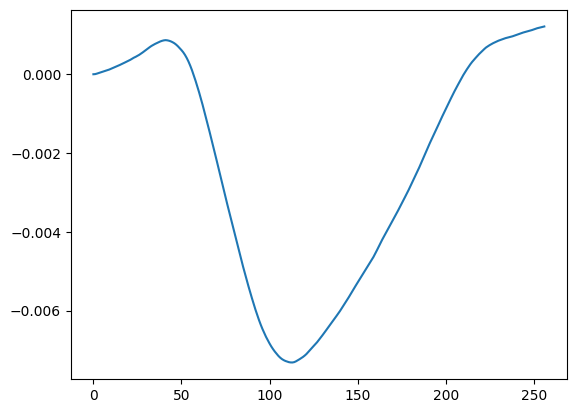

In [128]:
plt.plot(jnp.mean(test2[:, :1024,0], axis=0)-jnp.mean(test[:, :1025,0][:,::4], axis=0))

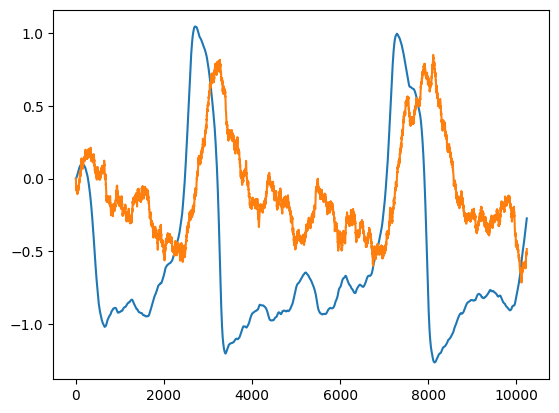

In [10]:
plt.plot(paths_1[10])

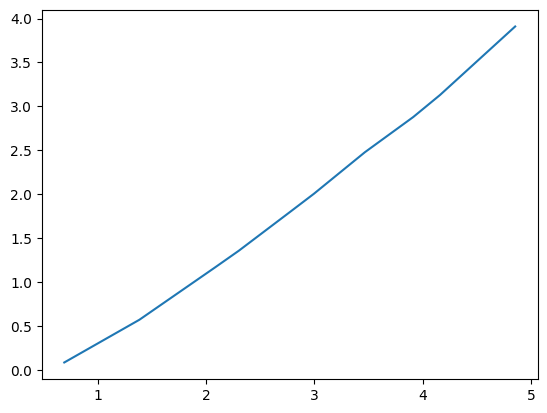

In [174]:
plt.plot(-jnp.log(deltas), -jnp.log(WEAK_GLOBAL_ERRORS_P1GroundTruth))

In [176]:
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(WEAK_GLOBAL_ERRORS_P1GroundTruth))
print(linear_regressor.coef_)

[0.9219163]


In [90]:
ts = jnp.insert(jnp.linspace(1/1024, 1, 1024),0,0)
np.savetxt(f'{prefix}_correct_mean_first.csv', jnp.array([ts, jnp.mean(paths_2[:,:,0], axis=0)]).T, delimiter=',', header='t,mean', comments="")
np.savetxt(f'{prefix}_correct_mean_secnd.csv', jnp.array([ts, jnp.mean(paths_2[:,:,1], axis=0)]).T, delimiter=',', header='t,mean', comments="")
np.savetxt(f'{prefix}_incorrect_mean_first.csv', jnp.array([ts, jnp.mean(paths_1[:,:,0], axis=0)]).T, delimiter=',', header='t,mean', comments="")
np.savetxt(f'{prefix}_incorrect_mean_secnd.csv', jnp.array([ts, jnp.mean(paths_1[:,:,1], axis=0)]).T, delimiter=',', header='t,mean', comments="")

In [87]:
prefix

'EKF1_SSM_FHN'

In [86]:
jnp.insert(jnp.linspace(1/1024, 1, 1024),0,0)

Array([0.0000000e+00, 9.7656250e-04, 1.9531250e-03, ..., 9.9804688e-01,
       9.9902344e-01, 1.0000000e+00], dtype=float32)

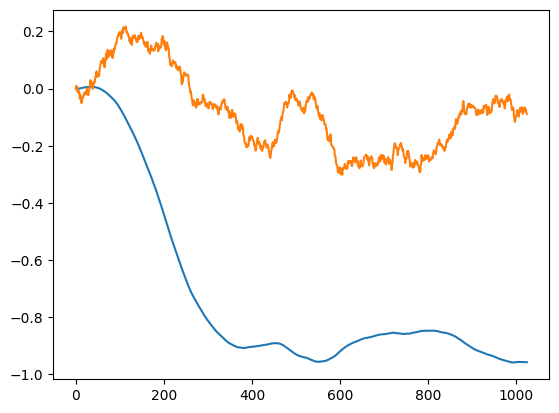

In [72]:
plt.plot(paths_2[10,:,:])

In [73]:
paths_1.shape

(100000, 1025, 2)

In [151]:

solver_name = "EKF0"
problem_name = "RND_LINEAR_SDE"
prefix = f"{solver_name}_{problem_name}"
folder = "./"

delta = 1/128
N = 128
fineN = N
Mdelta = 1
T = 1
Ndelta = T/delta
dims = jnp.array([1,2,4,8,16,32,64,128])

STRONG_GLOBAL_ERRORS_P1P2 = [
]
for dim in dims:
    N = int(N)
    Mdelta = int(Mdelta)
    fineN = int(fineN)
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}_{Mdelta}_{dim}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}_{fineN}_{dim}.npy')
    STRONG_GLOBAL_ERROR_P1P2 = jnp.mean(jnp.linalg.norm(paths_2 - paths_1, axis=-1), axis=0)[-1]
    STRONG_GLOBAL_ERRORS_P1P2.append(STRONG_GLOBAL_ERROR_P1P2)
STRONG_GLOBAL_ERRORS_P1P2 = jnp.array(STRONG_GLOBAL_ERRORS_P1P2)
plt.plot(jnp.log(dims), jnp.log(STRONG_GLOBAL_ERRORS_P1P2))

FileNotFoundError: [Errno 2] No such file or directory: './/EKF0_RND_LINEAR_SDE_pathwise_sols_128_1_64.npy'

In [144]:
paths_1[0]

Array([[ 1.        ],
       [ 0.90575826],
       [ 0.718197  ],
       [ 0.771408  ],
       [ 0.7005903 ],
       [ 0.8046586 ],
       [ 0.67839974],
       [ 0.31348768],
       [ 0.34190568],
       [ 0.3547514 ],
       [ 0.40236288],
       [ 0.75040317],
       [ 0.5876911 ],
       [ 0.2149515 ],
       [ 0.18014959],
       [ 0.11997361],
       [ 0.3235836 ],
       [ 0.02967667],
       [-0.3223569 ],
       [-0.45747384],
       [-0.7474879 ],
       [-0.23498392],
       [-0.12212142],
       [-0.0445757 ],
       [ 0.13734438],
       [ 0.08407188],
       [-0.12734443],
       [-0.10685886],
       [-0.14796646],
       [-0.06350771],
       [-0.04530296],
       [-0.23193918],
       [-0.3345133 ],
       [-0.64443344],
       [-0.5330021 ],
       [-0.5973161 ],
       [-0.51654917],
       [-0.4099479 ],
       [-0.2930144 ],
       [-0.26028782],
       [-0.3384363 ],
       [-0.38476732],
       [-0.6330104 ],
       [-0.51236266],
       [-0.58345574],
       [-0

In [145]:
paths_2[0]

Array([[ 1.        ],
       [ 0.9055662 ],
       [ 0.7188749 ],
       [ 0.7676837 ],
       [ 0.7006651 ],
       [ 0.801565  ],
       [ 0.6753813 ],
       [ 0.31315798],
       [ 0.34265634],
       [ 0.35516238],
       [ 0.40148208],
       [ 0.7440511 ],
       [ 0.5850377 ],
       [ 0.21231629],
       [ 0.17671463],
       [ 0.11594063],
       [ 0.31568518],
       [ 0.02550153],
       [-0.32643718],
       [-0.46180826],
       [-0.7481411 ],
       [-0.23710664],
       [-0.12324436],
       [-0.04785439],
       [ 0.13578685],
       [ 0.08237319],
       [-0.12389135],
       [-0.10165969],
       [-0.14116839],
       [-0.06091822],
       [-0.04193878],
       [-0.22985093],
       [-0.32862377],
       [-0.6338744 ],
       [-0.51863635],
       [-0.5811395 ],
       [-0.49935952],
       [-0.39292887],
       [-0.2768195 ],
       [-0.2475465 ],
       [-0.3233129 ],
       [-0.36489758],
       [-0.6101259 ],
       [-0.4887839 ],
       [-0.56243813],
       [-0

In [133]:
paths_1.shape

(100000, 129, 1)

In [134]:
paths_2.shape

(100000, 129, 1)